# **Import necessary libraries**


In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import cos, sin
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import mediapipe as mp
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# **Load dataset and print number of images**


In [2]:
dataset_folder = '/Users/ahmedbalta/Desktop/Projects/Face/AFLW2000'  
print(len(os.listdir(dataset_folder)))

4001


In [3]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Use 7 key landmarks
selected_landmarks = [1, 33, 263, 10, 234, 454, 152]

columns = ["image_name", "pitch", "yaw", "roll"] + \
          [f"landmark_{i}x" for i in selected_landmarks] + \
          [f"landmark_{i}y" for i in selected_landmarks]

df = pd.DataFrame(columns=columns)

I0000 00:00:1757927450.632702  214190 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1757927450.635706  214354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1757927450.641488  214354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Extract landmarks using Mediapipe

In [4]:
for file_name in os.listdir(dataset_folder):
    if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(dataset_folder, file_name)
        mat_path = os.path.join(dataset_folder, os.path.splitext(file_name)[0] + ".mat")

        data = loadmat(mat_path)
        pose_para = data["Pose_Para"][0][:3]
        pitch, yaw, roll = np.degrees(pose_para[0]), np.degrees(pose_para[1]), np.degrees(pose_para[2])

        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = face_mesh.process(image_rgb)
        landmarks_x, landmarks_y = [None]*len(selected_landmarks), [None]*len(selected_landmarks)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            for idx, lm_index in enumerate(selected_landmarks):
                lm = face_landmarks.landmark[lm_index]
                landmarks_x[idx] = lm.x
                landmarks_y[idx] = lm.y

        row = [file_name, pitch, yaw, roll] + landmarks_x + landmarks_y
        df.loc[len(df)] = row


W0000 00:00:1757927452.416942  214353 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/var/folders/qg/yszvx_2n0nggpslsn_32npgm0000gn/T/ipykernel_5021/2735628196.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = row
/var/folders/qg/yszvx_2n0nggpslsn_32npgm0000gn/T/ipykernel_5021/2735628196.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)]

In [5]:
X_raw = df.filter(like="landmark").apply(pd.to_numeric, errors="coerce").dropna()

In [6]:
def normalize_features(row):
    nose_x, nose_y = row["landmark_1x"], row["landmark_1y"]
    eye_left_x, eye_left_y = row["landmark_33x"], row["landmark_33y"]
    eye_right_x, eye_right_y = row["landmark_263x"], row["landmark_263y"]

    eye_dist = np.sqrt((eye_right_x - eye_left_x)**2 + (eye_right_y - eye_left_y)**2)
    if eye_dist == 0: eye_dist = 1e-6

    feats = []
    for i in selected_landmarks:
        x, y = row[f"landmark_{i}x"], row[f"landmark_{i}y"]
        feats.append((x - nose_x) / eye_dist)
        feats.append((y - nose_y) / eye_dist)

    return pd.Series(feats)

In [7]:
X = X_raw.apply(normalize_features, axis=1)
y_pitch = df.loc[X.index, "pitch"]
y_yaw   = df.loc[X.index, "yaw"]
y_roll  = df.loc[X.index, "roll"]

In [8]:
X.shape

(1850, 14)

In [9]:
X_train, X_test, y_pitch_train, y_pitch_test, y_yaw_train, y_yaw_test, y_roll_train, y_roll_test = train_test_split(
    X, y_pitch, y_yaw, y_roll, test_size=0.2, random_state=42
)

# **Train Models**

In [10]:
def build_rf():
    return RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

In [11]:
pitch_model = build_rf()
yaw_model   = build_rf()
roll_model  = build_rf()

pitch_model.fit(X_train, y_pitch_train)
yaw_model.fit(X_train, y_yaw_train)
roll_model.fit(X_train, y_roll_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42)

# **Evaluate model**

In [14]:
for name, model, y_true, y_pred in [
    ("Pitch", pitch_model, y_pitch_test, pitch_model.predict(X_test)),
    ("Yaw", yaw_model, y_yaw_test, yaw_model.predict(X_test)),
    ("Roll", roll_model, y_roll_test, roll_model.predict(X_test))
]:
    print(f"{name} -> MAE: {mean_absolute_error(y_true, y_pred):.4f}, "
          f"MSE: {mean_squared_error(y_true, y_pred):.4f}, "
          f"R²: {r2_score(y_true, y_pred):.4f}")

Pitch -> MAE: 5.8400, MSE: 118.8210, R²: 0.5457
Yaw -> MAE: 4.6751, MSE: 117.2087, R²: 0.8897
Roll -> MAE: 4.9469, MSE: 314.7009, R²: 0.0408


In [37]:
# Save models
joblib.dump(yaw_model, 'model_yaw.pkl')
joblib.dump(pitch_model, 'model_pitch.pkl')
joblib.dump(roll_model, 'model_roll.pkl')

['model_roll.pkl']

# **Function to draw axis on image**


In [16]:
def draw_pose_axes(img, pitch, yaw, roll, nose_point, length=100):
    pitch = -pitch
    h, w, _ = img.shape
    cx, cy = int(nose_point[0] * w), int(nose_point[1] * h)

    pitch, yaw, roll = np.radians([pitch, yaw, roll])
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(pitch), -np.sin(pitch)],
                    [0, np.sin(pitch),  np.cos(pitch)]])
    R_y = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                    [0, 1, 0],
                    [-np.sin(yaw), 0, np.cos(yaw)]])
    R_z = np.array([[np.cos(roll), -np.sin(roll), 0],
                    [np.sin(roll),  np.cos(roll), 0],
                    [0, 0, 1]])
    R = R_z @ R_y @ R_x

    axis_x = R @ np.array([length, 0, 0])
    axis_y = R @ np.array([0, -length, 0])
    axis_z = R @ np.array([0, 0, -length])

    def project(pt): return int(cx + pt[0]), int(cy + pt[1])
    x2, y2, z2 = project(axis_x), project(axis_y), project(axis_z)

    cv2.arrowedLine(img, (cx, cy), x2, (0, 0, 255), 3)   # roll → red
    cv2.arrowedLine(img, (cx, cy), y2, (0, 255, 0), 3)   # pitch → green
    cv2.arrowedLine(img, (cx, cy), z2, (255, 0, 0), 3)   # yaw → blue

    return img

# **Function to predict pose from image**


In [17]:
def predict_pose(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found:", image_path)
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        print("No face detected!")
        return image

    face_landmarks = results.multi_face_landmarks[0]
    nose = face_landmarks.landmark[1]
    eye_left, eye_right = face_landmarks.landmark[33], face_landmarks.landmark[263]

    eye_dist = np.sqrt((eye_right.x - eye_left.x)**2 + (eye_right.y - eye_left.y)**2)
    if eye_dist == 0: eye_dist = 1e-6

    feats = []
    for idx in selected_landmarks:
        lm = face_landmarks.landmark[idx]
        feats.append((lm.x - nose.x) / eye_dist)
        feats.append((lm.y - nose.y) / eye_dist)

    feats = np.array(feats).reshape(1, -1)

    pitch = pitch_model.predict(feats)[0]
    yaw   = yaw_model.predict(feats)[0]
    roll  = roll_model.predict(feats)[0]

    print(f"Predicted -> Pitch: {pitch:.2f}, Yaw: {yaw:.2f}, Roll: {roll:.2f}")

    nose_point = (nose.x, nose.y)
    return draw_pose_axes(image.copy(), pitch, yaw, roll, nose_point)

Predicted -> Pitch: 1.24, Yaw: 44.51, Roll: -5.59


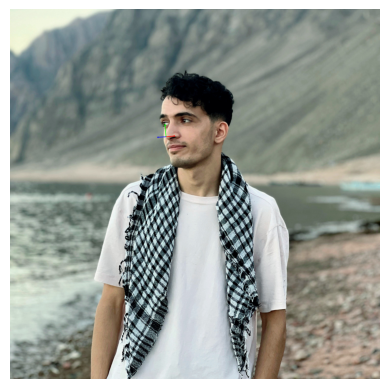

In [19]:
test_image = "/Users/ahmedbalta/Desktop/Projects/Face/20250330_035252.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [20]:
from collections import deque
import numpy as np

class PoseSmoother:
    def __init__(self, window=5):
        self.pitch_hist = deque(maxlen=window)
        self.yaw_hist = deque(maxlen=window)
        self.roll_hist = deque(maxlen=window)

    def update(self, pitch, yaw, roll):
        self.pitch_hist.append(pitch)
        self.yaw_hist.append(yaw)
        self.roll_hist.append(roll)

        smooth_pitch = np.mean(self.pitch_hist)
        smooth_yaw   = np.mean(self.yaw_hist)
        smooth_roll  = np.mean(self.roll_hist)
        return smooth_pitch, smooth_yaw, smooth_roll

In [32]:
import cv2
import numpy as np

def process_video(video_path, output_path="output.mp4", frame_skip=1, smooth_window=2):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Error opening video file:", video_path)
        return

    # Use mp4v codec for .mp4 output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width, height = int(cap.get(3)), int(cap.get(4))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    smoother = PoseSmoother(window=smooth_window)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        if frame_count % frame_skip != 0:
            continue

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]

            # === SAME as predict_pose ===
            nose = face_landmarks.landmark[1]
            eye_left, eye_right = face_landmarks.landmark[33], face_landmarks.landmark[263]

            eye_dist = np.sqrt((eye_right.x - eye_left.x)**2 + (eye_right.y - eye_left.y)**2)
            if eye_dist == 0: 
                eye_dist = 1e-6

            feats = []
            for idx in selected_landmarks:
                lm = face_landmarks.landmark[idx]
                feats.append((lm.x - nose.x) / eye_dist)
                feats.append((lm.y - nose.y) / eye_dist)

            feats = np.array(feats).reshape(1, -1)

            # Predictions
            pitch = pitch_model.predict(feats)[0]
            yaw   = yaw_model.predict(feats)[0]
            roll  = roll_model.predict(feats)[0]

            # Smooth predictions
            pitch, yaw, roll = smoother.update(pitch, yaw, roll)

            nose_point = (nose.x, nose.y)
            frame = draw_pose_axes(frame, pitch, yaw, roll, nose_point)

        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Processed video saved to: {output_path}")


In [36]:
video_path = "/Users/ahmedbalta/Desktop/Projects/Face/final.mov"
output_path = "/Users/ahmedbalta/Desktop/Projects/Face/output555555.mp4"
process_video(video_path, output_path, frame_skip=1)

✅ Processed video saved to: /Users/ahmedbalta/Desktop/Projects/Face/output555555.mp4
